In [230]:
import torch
import pickle as pkl
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, Dataset

In [231]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [232]:
# get data
with open(r"C:\Users\ricco\OneDrive\Desktop\Grad_Schools\Schools\UC_Riverside\PHYS_206\nbuddies\training_data\test_1_sim.pkl", "rb") as f:
    sim_data = pkl.load(f)
    # print(sim_data)

In [233]:
# bh = sim_data["Final_Data"][0]["data"][0]
# print(bh.__dict__)

In [234]:
# define functions

def bh_to_vector(bh) -> list:
    """
    Convert black hole properties to array
    """

    return np.concatenate([
        [bh.mass],
        bh.position,
        bh.velocity,
        bh.acceleration,
        bh.jerk,
        bh.snap
    ])

def bh_to_pos(bh) -> list[float]:
    """
    Return black hole position vector
    """
    return bh.position


In [235]:
# print(type(sim_data["seeds"]))
# print(type(sim_data["seeds"][0]))
# print(sim_data["seeds"][0])
# print(type(sim_data["seeds"][0]))
# print(sim_data["seeds"][0])
# print(type(sim_data["Final_Data"][0]))
# print(type(sim_data["Final_Data"][0]["data"][0]))

In [236]:
ICs = sim_data["ICs"][0]             # unwrap dict
finals = sim_data["Final_Data"][0]   # unwrap dict

bh_initial = ICs["data"]             # initial BlackHole list
bh_final   = finals["data"]          # final BlackHole list

X = np.array([bh_to_vector(bh) for bh in bh_initial], dtype=np.float32)
Y = np.array([bh_to_pos(bh) for bh in bh_final], dtype=np.float32)

print("Initial BHs:", len(bh_initial))
print("Final BHs:", len(bh_final))
print("X shape:", X.shape)
print("Y shape:", Y.shape)

# print(sim_data.keys())

Initial BHs: 86
Final BHs: 86
X shape: (86, 16)
Y shape: (86, 3)


In [237]:
class BlackHoleDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

dataset = BlackHoleDataset(X, Y)
loader = DataLoader(dataset, batch_size=16, shuffle=True)


In [238]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(16, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3),   # 3 outputs = x,y,z
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()


In [239]:
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [240]:
epochs = 200

for epoch in range(epochs):
    total_loss = 0.0
    for X_batch, Y_batch in loader:
        optimizer.zero_grad()
        pred = model(X_batch)
        loss = criterion(pred, Y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch:3d} | Loss = {total_loss:.4f}")


Epoch   0 | Loss = 201752677711872.0000
Epoch  20 | Loss = 457091944.5000
Epoch  40 | Loss = 1933.7606
Epoch  60 | Loss = 605.7217
Epoch  80 | Loss = 777.3849
Epoch 100 | Loss = 816.6037
Epoch 120 | Loss = 891.5109
Epoch 140 | Loss = 1947.3903
Epoch 160 | Loss = 3862.9472
Epoch 180 | Loss = 2056.2070


In [241]:
i = 6  # choose any BH index
sample = torch.tensor(X[i], dtype=torch.float32).unsqueeze(0)  # shape [1,16]
predicted = model(sample).detach().numpy()                     # shape [1,3]
predicted = predicted[0]                                       # remove batch dim

print("Predicted final position:", predicted)
print("True final position:", Y[i])

Predicted final position: [ -7.6338763 -13.061479   13.009223 ]
True final position: [ 6.0147605 -7.213442   8.1336565]


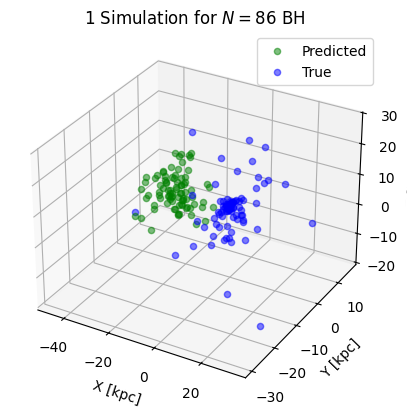

In [ ]:
# 3D plot
ax = plt.figure().add_subplot(projection='3d')

for i in range(len(X)):
    sample = torch.tensor(X[i], dtype=torch.float32).unsqueeze(0)  # shape [1,16]
    predicted = model(sample).detach().numpy()                     # shape [1,3]
    predicted = predicted[0]                                       # remove batch

    # Add label only on the first point
    if i == 0:
        ax.scatter(predicted[0], predicted[1], predicted[2],
                   label="Predicted", color="g", alpha=0.5)
        ax.scatter(Y[i][0], Y[i][1], Y[i][2],
                   label="True", color="b", alpha=0.5)
    else:
        ax.scatter(predicted[0], predicted[1], predicted[2],
                   color="g", alpha=0.5)
        ax.scatter(Y[i][0], Y[i][1], Y[i][2],
                   color="b", alpha=0.5)


# Make legend, set labels
ax.legend()
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_zlabel('Z [kpc]')
ax.set_title(fr"1 Simulation for $N={len(Y)}$ BH")
plt.show()